# CPSC 536M - Homework 2
Emma Hansen and Naomi Graham

October 2020

In [2]:
# Load packages
using Images, FileIO, ImageMagick, Zygote, Random, LinearAlgebra
using PyPlot

In [3]:
# Functions
function linesearch(grad_f,s,d)
    #alpha_upper0 = 1
    #alpha_lower0 = 0
    alpha_mid = 0.5
    alpha_range = 0.5
    stop = 100
    alpha_storage = zeros(stop+1)
    alpha_storage[1] = alpha_mid
    
    for i=1:stop
        val_mid = dot(-grad_f, alpha_mid * s + (1-alpha_mid) * d) / (norm(grad_f)*norm(alpha_mid * s + (1-alpha_mid) * d))
        alpha_upper = alpha_mid + (1/2)*alpha_range
        alpha_lower = alpha_mid - (1/2)*alpha_range
        
        val_upper = dot(-grad_f, alpha_upper * s + (1-alpha_upper) * d) / (norm(grad_f)*norm(alpha_upper * s + (1-alpha_upper) * d))
        val_lower = dot(-grad_f, alpha_lower * s + (1-alpha_lower) * d) / (norm(grad_f)*norm(alpha_lower * s + (1-alpha_lower) * d))
        
        if val_upper > val_mid # note: I think something is wrong with this criteria...
            alpha_mid = alpha_upper
        elseif val_lower > val_mid
            alpha_mid = alpha_lower
        end
        
#         if val_upper > val_mid # note: something IS wrong with this one...
#             alpha_lower0 = alpha_mid
#             alpha_mid = alpha_upper0
            
#         elseif val_lower > val_mid
#             alpha_upper0 = alpha_mid
#             alpha_mid = alpha_lower0
            
#         else
#             alpha_upper0 = alpha_upper1
#             alpha_lower0 = alpha_lower1
#         end
        
        alpha_range = (1/2) * alpha_range
        alpha_storage[i+1] = alpha_mid
    end
    return alpha_mid, alpha_storage
end
    
    

# to solve <s,grad(f)>
function get_s(D,grad_f)
    n,m = size(D)
    eps = 0.001
    stop = 100
    
    Dnorm = [norm(D[:,i]) for i=1:size(D,2)]
    IP = ((-grad_f)' * D) ./ (norm(grad_f) .* Dnorm') 
    ind_max = argmax(IP)[2]
    s0 = D[:,ind_max]
    val0 = s0' * (-grad_f)
    
    s1 = ones((n,1))
    D_new = D
    D_new[:,ind_max] = -D[:,ind_max] # making it negative ensures that it won't be picked as the next max!
    
    max_inds = zeros((m,1))
    max_inds[1] = ind_max
    
    for j=2:m
        Dnorm = [norm(D_new[:,i]) for i=1:size(D_new,2)]
        IP = ((-grad_f)' * D_new) ./ (norm(grad_f) .* Dnorm') 
        ind_max = argmax(IP)[2]
        d = D_new[:,ind_max]
        
        alpha, = linesearch(grad_f,s0,d)
        s1 = alpha * s0 + (1-alpha) * d
        
        val1 = s1' * (-grad_f)
        
        if val1 < val0
            return s0,max_inds
            break
        end
        
        s0 = s1
        D_new[:,ind_max] = -D[:,ind_max]
        val0 = val1
        max_inds[j] = ind_max
    end
end
        

# Frank-Wolfe

# function to minimize

get_s (generic function with 1 method)

In [4]:
# Good to know functions
x = [1,2,3,4]

function normsquared(x)
    return sum(x .^ 2)
end

normsquared(x)
gradient(y -> normsquared(y),x)

([2, 4, 6, 8],)

## Testing linesearch function
The non-random test case is based on the following figure:

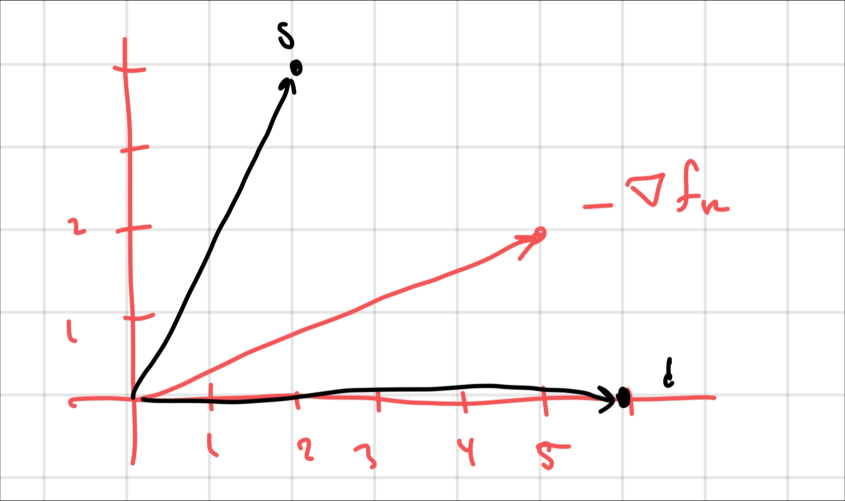

In [5]:
linesearch_file = "linesearch_example.jpg"
linesearch_ex = load(linesearch_file)

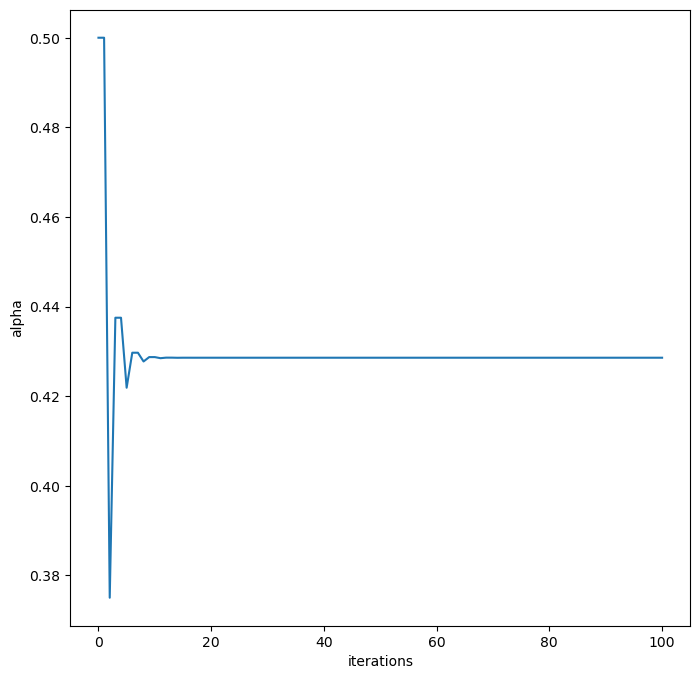

In [6]:
# grad_f = 2 .* (rand(Float16,(5,1)) .- 0.5) 
# s = 2 .* (rand(Float16,(5,1)) .- 0.5)
# d = 2 .* (rand(Float16,(5,1)) .- 0.5)
# print([grad_f,s,d])

grad_f = [-5,-2]
s = [2,4]
d = [6,0]

alpha_mid,alpha_storage = linesearch(grad_f,s,d);

fig = figure(figsize=(8,8))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(alpha_storage);
ax1.set_ylabel("alpha");
ax1.set_xlabel("iterations");

## Testing argmin function
The test for the argmin function is the following example:

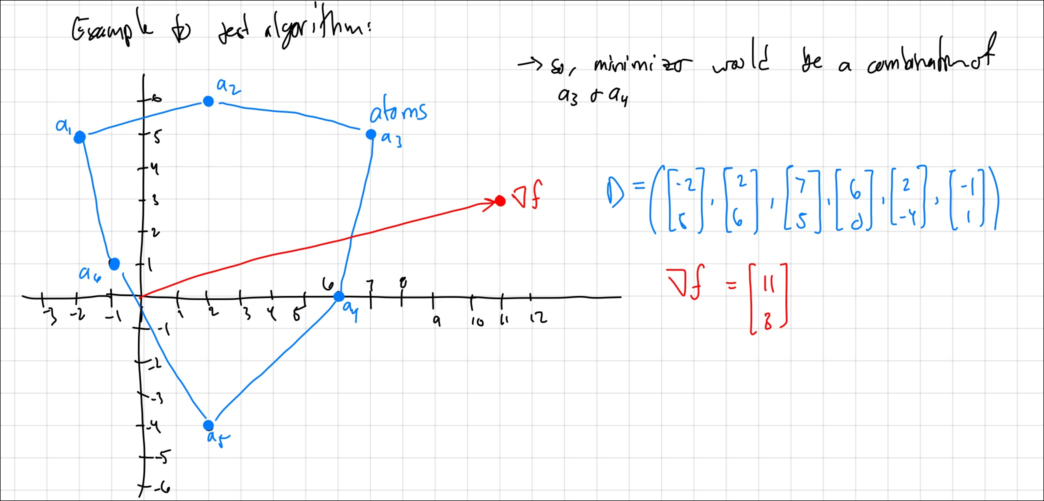

In [7]:
argmin_file = "argmin_example.jpg"
argmin_ex = load(argmin_file)

In [8]:
D = hcat([-2;5],[2;6],[7;5],[6;0],[2;-4],[-1;1])
grad_f = [-11;-3];

s,max_inds = get_s(D,grad_f)
print("argmin is: ")
println(s)
print("the atoms used are:")
print(max_inds[max_inds .> 0])

argmin is: [6.346153855352895, 1.7307692767644767]
the atoms used are:[4.0, 3.0]

## Actual project?

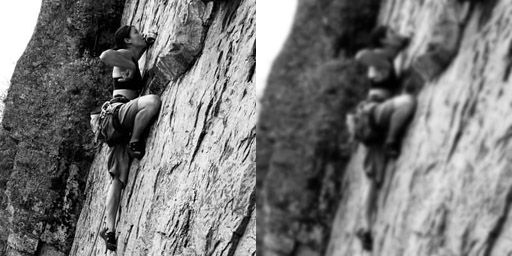

In [9]:
# Load blurry and original images
original_path = "hw2_image256.jpg"
blurry_path = "hw2_image256_blurred.jpg"
original = load(original_path)
blurry = load(blurry_path)

mosaicview(original, blurry; nrow=1)